<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21388934/cnn_sentimantAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing data**

In [3]:
import os

# Change to the desired directory (example path)
os.chdir('/content/drive/MyDrive/AI_ML/assigment2/amazonReview')

In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'amazon-reviews-for-sentianalysis-finegrained-csv:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2078107%2F3499094%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20241003%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20241003T164549Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D25a30a2ad799910d48f45f67793fb1d09f31560ae3773fa14870108018fa213261ae62aeb020867952a30d8094a21359c2546a6475193ac986bc2645a191d848c7223dbd5c68600aeb8f17d5a979be9750827328816b6743cf0d74ca79e5a28878f8606f4d3cd2176678d18b8a70a20bbf9be8037aa238d4b56bd1a0ba1a8d1fb4003bbd12f51fa6d438aaa8a7e8fa90a9291e62969f7df78c34dc6a71c76fb2f1c11e2964127136ec4d5554e9f1bdd7c530f8ddf987a08dd6cb91a849e4e98a2089149d22cb00ca687688c756071af4270e392fd79699c1f4a35ca16597523ca8bfe37fea11d5911465ea51d6eb17c1e3663da806763c8ef4e96e1f0a9ae9ab'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 654512809 bytes downloaded
Downloaded and uncompressed: amazon-reviews-for-sentianalysis-finegrained-csv
Data source import complete.


**Checking the data set**

In [5]:
!pip install tensorflow


In [6]:
import pandas as pd
import numpy as np
import requests
import zipfile
import os
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dropout, GlobalMaxPooling1D, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Load the dataset
train = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/train.csv')
test = pd.read_csv('../input/amazon-reviews-for-sentianalysis-finegrained-csv/amazon_review_fine-grained_5_classes_csv/test.csv')

# Check the column names
print("Training data set")
print(train.columns)
print(train.shape)

print("Testing data set")
print(test.columns)
print(test.shape)

Training data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(3000000, 3)
Testing data set
Index(['class_index', 'review_title', 'review_text'], dtype='object')
(650000, 3)


In [7]:
train_sample = train.sample(n=200000, random_state=42)
test_sample = test.sample(n=60000, random_state=42)

In [8]:
texts = train_sample['review_text'].astype(str).values  # Text reviews
labels = train_sample['class_index'].values  # Sentiment classes


In [9]:
max_length = 200  # Max length for each review
vocab_size = 10000  # Vocabulary size
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')


In [10]:
# Preprocess Labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels, num_classes=5)

In [11]:
# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    padded_sequences, categorical_labels, test_size=0.2, random_state=42
)

In [12]:

test_texts = test_sample['review_text'].astype(str).values  # Text reviews from test set
test_labels = test_sample['class_index'].values  # Sentiment classes from test set
# Tokenize and pad the test texts
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')



In [13]:
# Convert sentiment classes to numerical labels for test data
test_encoded_labels = label_encoder.transform(test_labels)  # Use transform instead of fit_transform
test_categorical_labels = to_categorical(test_encoded_labels, num_classes=5)


In [14]:
def download_glove(glove_url, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Download the GloVe file
    response = requests.get(glove_url)
    zip_file_path = os.path.join(output_dir, 'glove.6B.zip')

    with open(zip_file_path, 'wb') as f:
        f.write(response.content)

    # Extract the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(output_dir)

    print(f"GloVe embeddings downloaded and extracted to {output_dir}")

# Load GloVe embeddings into a dictionary
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.array(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# URL for GloVe 300-dimensional embeddings
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
output_directory = "./glove_embeddings"

# Download and extract GloVe embeddings
download_glove(glove_url, output_directory)

# Load the GloVe embeddings (for 300d)
glove_file_path = './glove_embeddings/glove.6B.300d.txt'
glove_embeddings = load_glove_embeddings(glove_file_path)

# Print the number of loaded word vectors
print(f'Loaded {len(glove_embeddings)} word vectors.')


GloVe embeddings downloaded and extracted to ./glove_embeddings
Loaded 400000 word vectors.


In [15]:
# Prepare the embedding matrix
word_index = tokenizer.word_index
embedding_dim = 300  # Dimensionality of GloVe embeddings

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Fill the embedding matrix with GloVe vectors for words in our vocabulary
for word, index in word_index.items():
    if index < vocab_size:
        embedding_vector = glove_embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector


In [32]:
from keras.layers import LeakyReLU
# Build the model
model = Sequential()

# Add the Embedding Layer with GloVe embeddings and set trainable=False
model.add(Embedding(input_dim=vocab_size,
                    output_dim=embedding_dim,
                    input_length=max_length,
                    weights=[embedding_matrix],
                    trainable=False))  # Freeze the GloVe embeddings


model.add(Conv1D(filters=128, kernel_size=5, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU with alpha=0.01
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Add additional Conv layers with Batch Normalization
model.add(Conv1D(filters=128, kernel_size=5, kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU with alpha=0.01
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))

# Add Global Max Pooling Layer
model.add(GlobalMaxPooling1D())

# Dense layer with L1-L2 Regularization (replace Conv1D with Dense)
model.add(Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.5))  # Increase Dropout to reduce overfitting

# Output Layer for multi-class classification (5 classes)
model.add(Dense(5, activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train the model
history = model.fit(
    X_train,  # Use training data padded sequences
    y_train,  # Use one-hot encoded labels
    epochs=30,
    batch_size=64,
    validation_data=(X_val, y_val),  # Validation data
    callbacks=[reduce_lr]  # Include the ReduceLROnPlateau callback
)

Epoch 1/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.2428 - loss: 49.5917 - val_accuracy: 0.3155 - val_loss: 3.6403 - learning_rate: 1.0000e-04
Epoch 2/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 38s 8ms/step - accuracy: 0.4019 - loss: 2.6187 - val_accuracy: 0.4394 - val_loss: 1.5696 - learning_rate: 1.0000e-04
Epoch 3/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - accuracy: 0.4122 - loss: 1.5773 - val_accuracy: 0.4155 - val_loss: 1.5280 - learning_rate: 1.0000e-04
Epoch 4/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - accuracy: 0.4212 - loss: 1.5137 - val_accuracy: 0.4443 - val_loss: 1.4586 - learning_rate: 1.0000e-04
Epoch 5/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.4271 - loss: 1.4916 - val_accuracy: 0.4438 - val_loss: 1.4505 - learning_rate: 1.0000e-04
Epoch 6/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.4319 - loss: 1.4803 - val_accuracy: 0.4444 - val_loss: 1.4394 - learning_rate: 1.0000e-04
Epoch 7/30
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s

In [33]:
test_loss, test_acc = model.evaluate(test_padded_sequences, test_categorical_labels)
print(f'Test Accuracy: {test_acc}')


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.4508 - loss: 1.3440
Test Accuracy: 0.45260000228881836


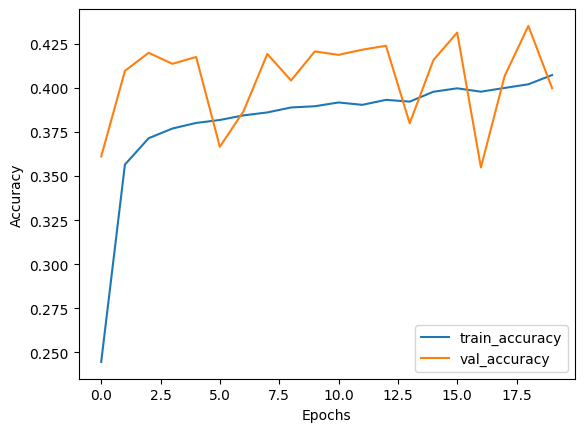

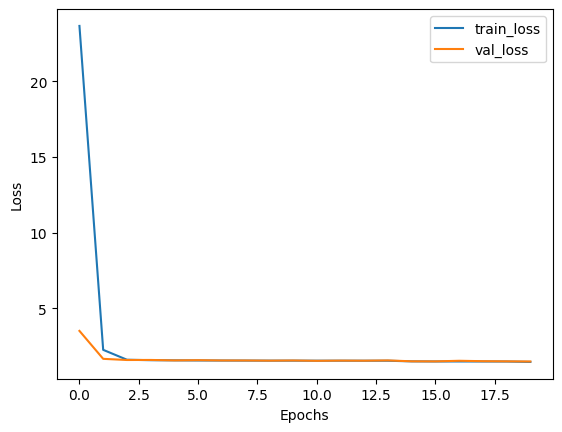

In [30]:
# Step 12: Plot Training and Validation Loss/Accuracy
import matplotlib.pyplot as plt

# Accuracy plot
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()